# Team 137: Recsys 137
## Sujay Thakur
## Simon Warchol
## Jovin Leong

___

This notebook contains the bulk of our code; it runs only when we have our augmented data in a nearby directory. We also include our code which we used to interact with the Spotify API; these code blocks have been commented out and the API keys have been hidden.

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import spotipy
import spotipy.util as util
%matplotlib inline

### Data collection
The following code reads data from the _Million Playlists Dataset_ and extracts the additional audio features used in our model. The code block has been commented out and the API IDs and secret are hidden.

In [2]:
## Code to extract song features from Spotipy;
## Commented out to avoid errors

# import os
# import sys
# from json.decoder import JSONDecodeError

# username="Hidden"
# client_id="Hidden"
# client_secret="Hidden"
# redirect_uri='https://google.com'

# try:
#     token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
# except (AttributeError, JSONDecodeError):
#     os.remove(f".cache-{username}")
#     token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)

# spotify = spotipy.Spotify(auth=token)

# attrs=['danceability',
#   'energy',
#   'key',
#   'loudness',
#   'mode',
#   'speechiness',
#   'acousticness',
#   'instrumentalness',
#   'liveness',
#   'valence',
#   'tempo',
#   'type',
#   'id',
#   'uri',
#   'track_href',
#   'analysis_url',
#   'duration_ms',
#   'time_signature']

# start=int(sys.argv[1])
# end=int(sys.argv[2])
# songs=list(range(start, end))

# for song in songs:
#     df1 = pd.read_csv('Songs/songs{}.csv'.format(song))
#     for key in attrs:
#         df1[key]=0
        
#     i=0
#     j=99
#     ender=0
#     error=0

#     while ender==0:
#         if j>=df1.shape[0]:
#             j=df1.shape[0]
#             ender=1
#         try:
#             output = spotify.audio_features(tracks=df1.loc[i:j]['track_uri'].values)
#             for key in output[0]:
#                 df1.loc[i:j, key]=np.array([d[key] for d in output])
#             i=j+1
#             j+=100
        
#         except TypeError:
#             print('Error with File{} in section {}-{}'.format(song, i,j))
#             error=1
#             break

#     if error==0:  
#         export_csv = df1.to_csv ('songs_mod/songs{}.csv'.format(song))
#         print('Finished File {}'.format(song))


---

### Preprocessing
We read in the songs data, with all required attributes. We then prepare a Numpy array of the required numerical values, which is standardised to prevent any one attribute from dominating.

In [3]:
def preprocess_numeric(path):
    '''Read in songs CSV and output Numpy array of the numeric columns after standardising.'''
    df = pd.read_csv(path)
    df_numeric = df[['danceability','energy','loudness','speechiness','acousticness','instrumentalness',\
        'liveness','valence','tempo']]
    X_scaled = StandardScaler().fit_transform(df_numeric)
    
    return df, np.array(df_numeric), X_scaled

In [4]:
df, X_unscaled, X_train = preprocess_numeric('test_data/songs620.csv')

---

### Visualisation
We can plot the correlation scatters for all attributes. Note that features like energy and loudness seem to feature collinearity. We can choose to deal with this by either dropping one of the attributes or by downscaling one.

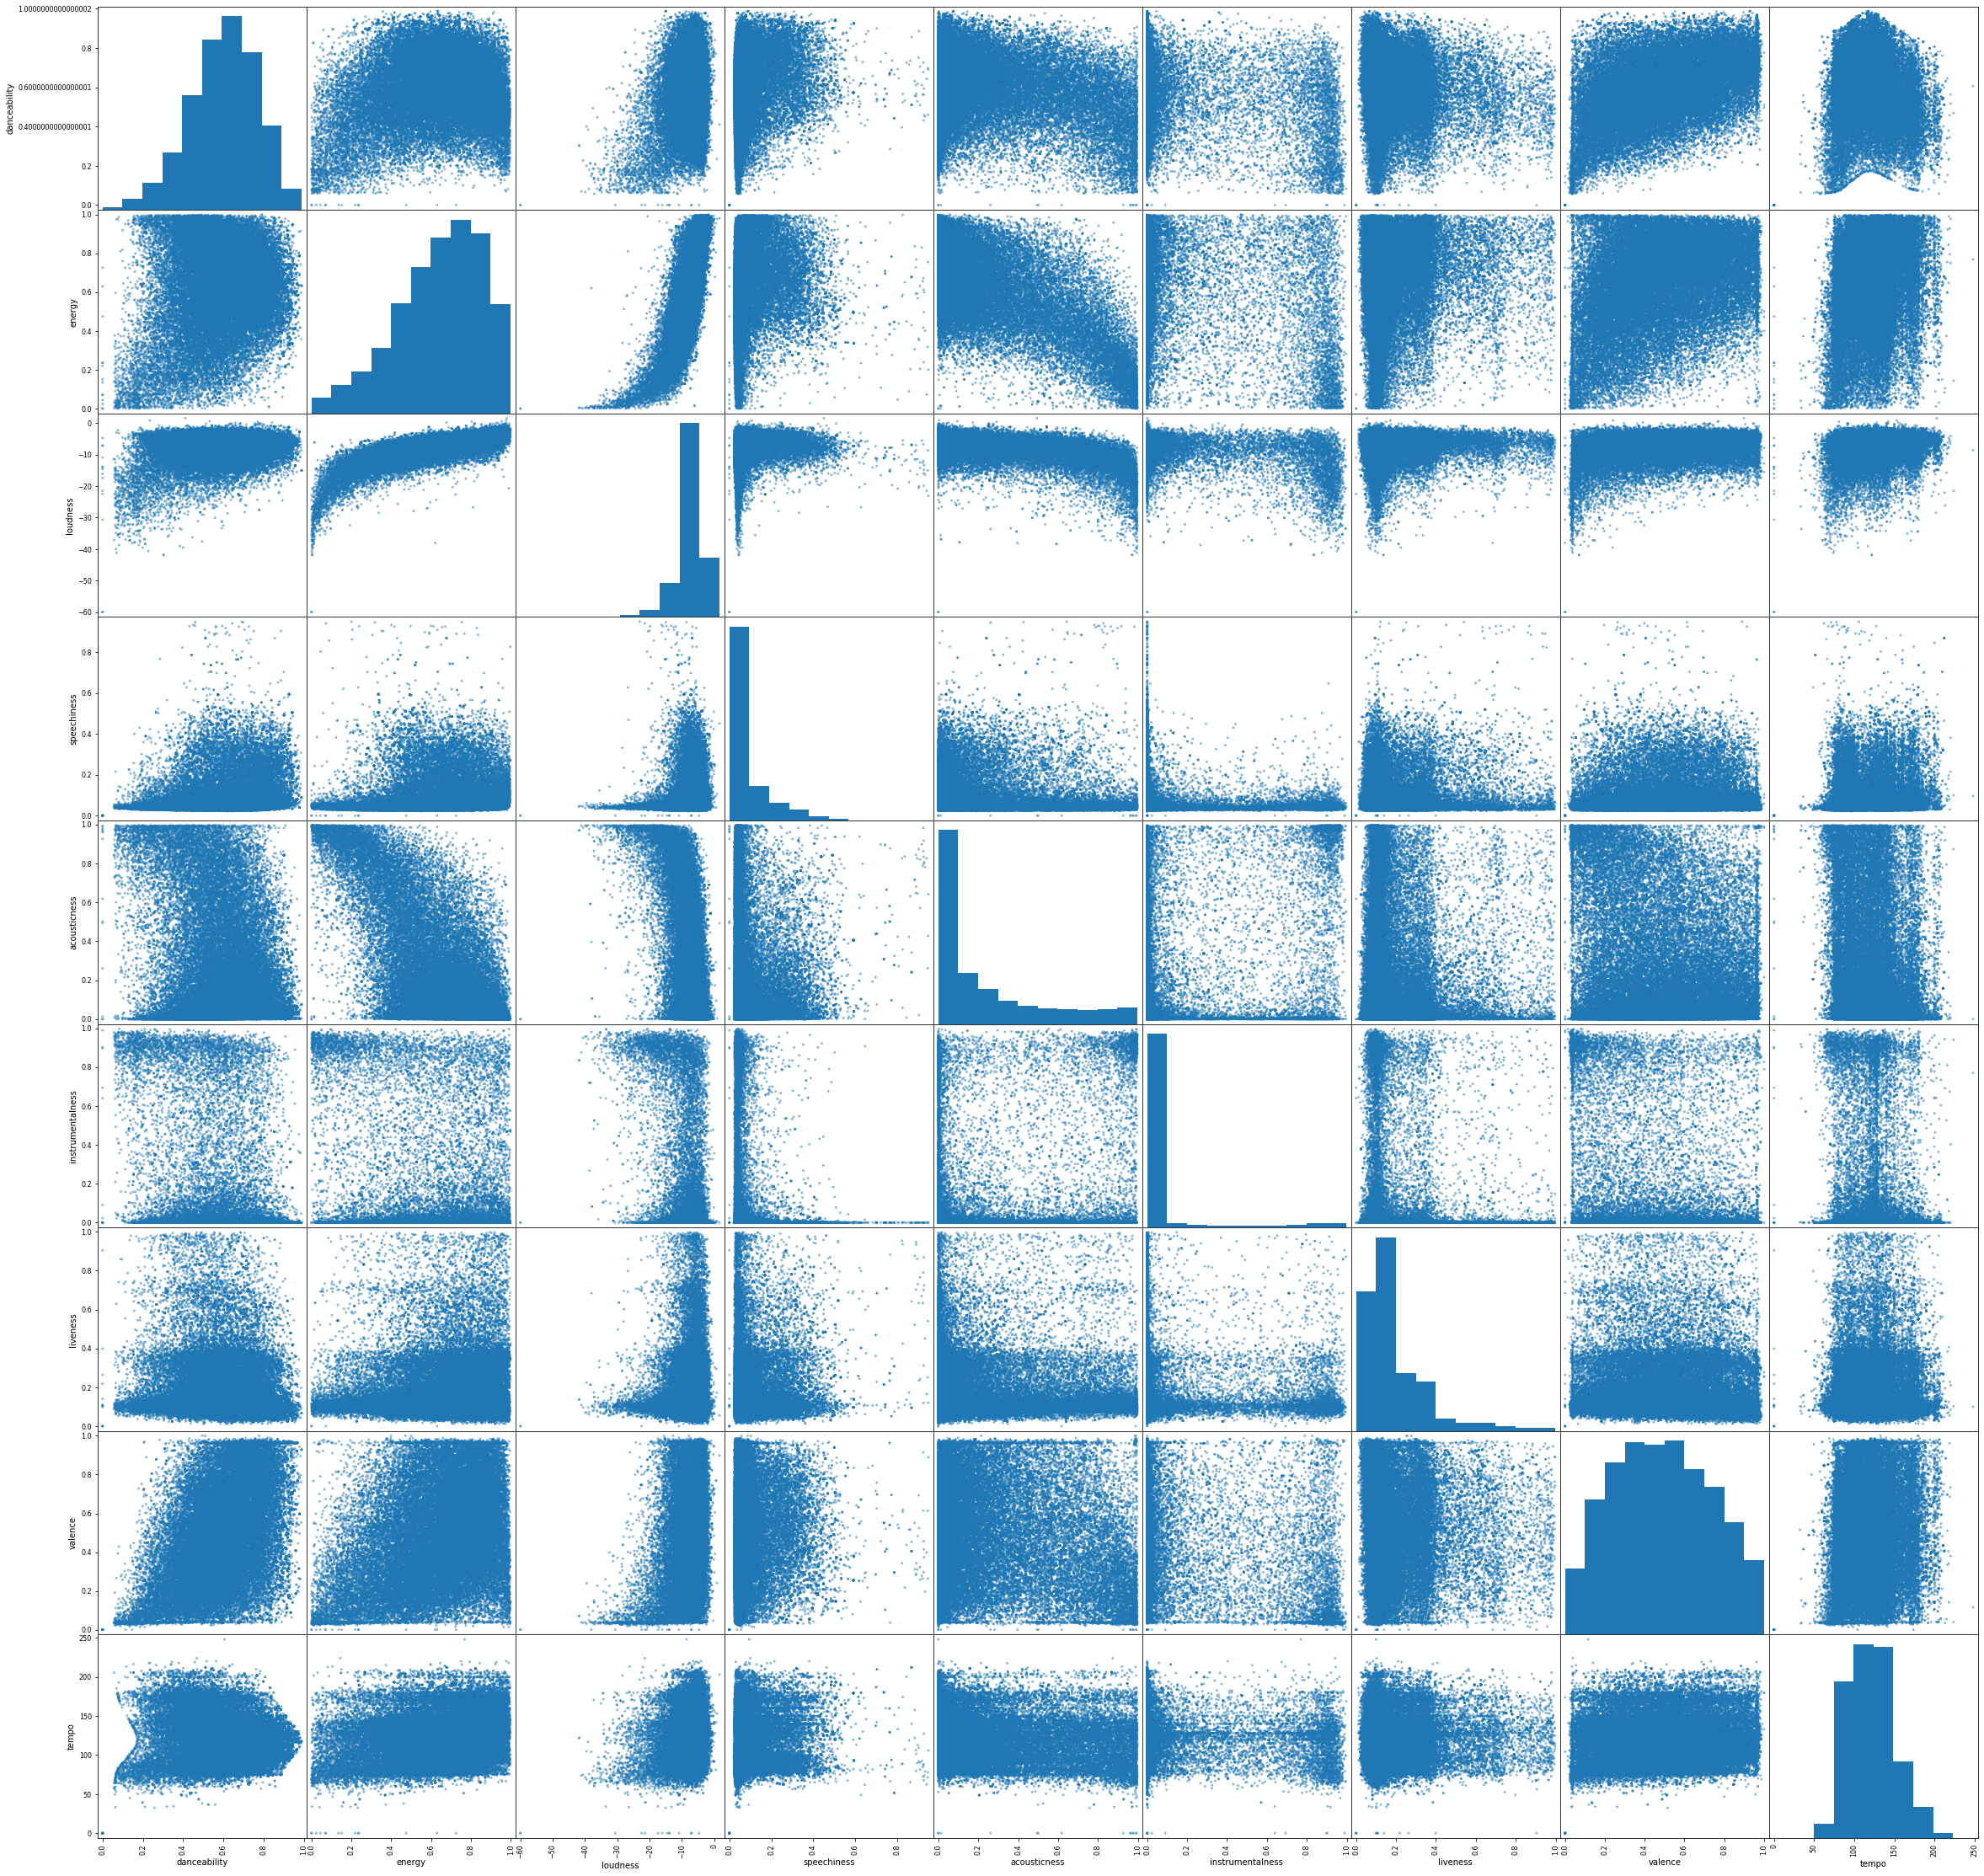

In [5]:
cor_columns = ['danceability','energy','loudness','speechiness','acousticness','instrumentalness',\
        'liveness','valence','tempo']
scatter_matrix(df[cor_columns], figsize=(40, 40))
plt.show()

Since the data has already been standardised, we can also compute the PCA vectors and visualise all pairs in a matrix. This would give some intuition for the number of clusters we might expect in the data.

In [6]:
pca=PCA().fit(X_train)
pca_X_train=pca.transform(X_train)

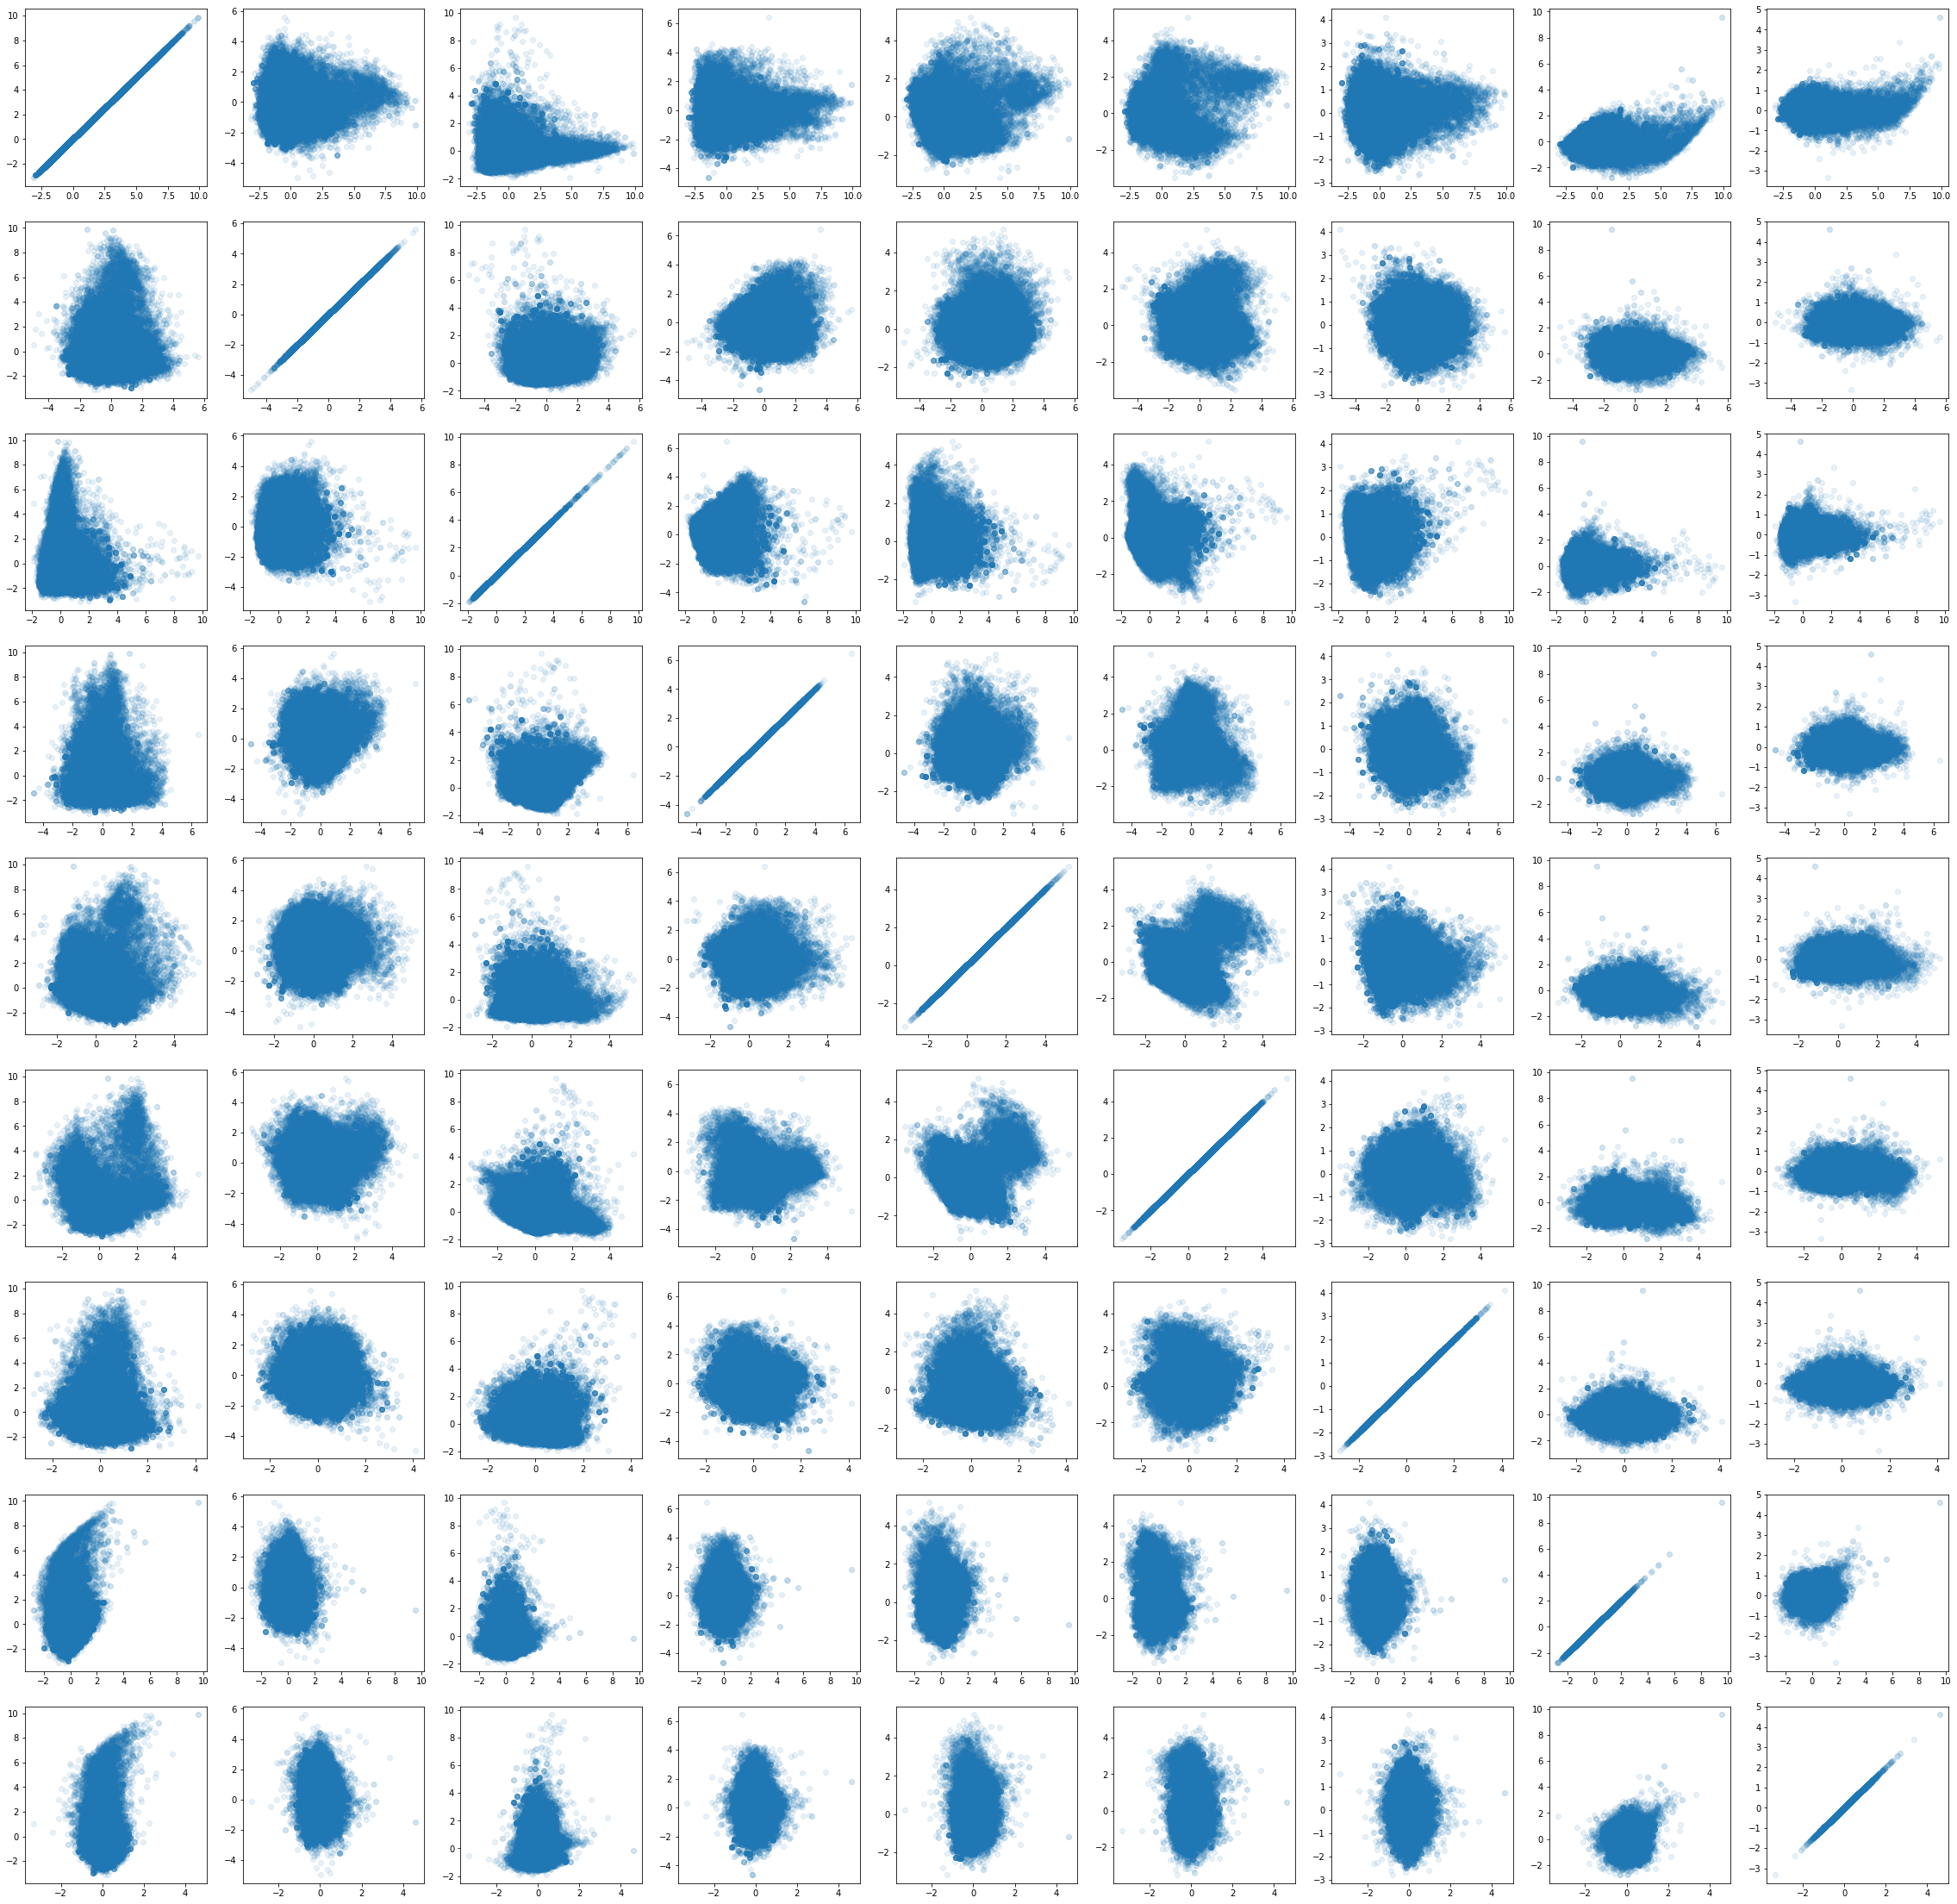

In [7]:
fig, ax=plt.subplots(9,9, figsize=(40,40))
for i in range(9):
    for j in range(9):
        ax[i,j].scatter(pca_X_train[:,i], pca_X_train[:,j], alpha=0.1)
plt.show()

We see roughly 3 clusters, and can now fit these using K-means to get some intuition. We note that the learned cluster centers correspond correctly to the 3 clusters we visually saw in the PCA projections.

In [8]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(PCA().fit_transform(X_unscaled))
pd.value_counts(kmeans.labels_)

2    29653
1    24675
0    11935
dtype: int64

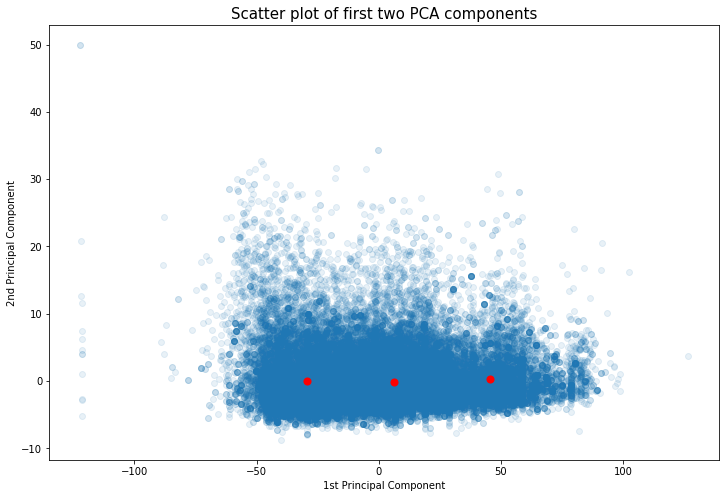

In [9]:
plt.figure(figsize=(12,8))
plt.scatter(PCA().fit_transform(X_unscaled)[:,0], PCA().fit_transform(X_unscaled)[:,1], alpha=0.1)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r', s=50)
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.title('Scatter plot of first two PCA components', fontsize=15)
plt.show()

### Recommendations based on Gaussian Mixture Models and Nearest Neighbours
Note that when a user indicates that they like a song, we only focus on the playlists that the song is a part of. We can fit a GMM and NN to this data. This allows us to generate recommendations based on two techniques.

**GMM**: We can fit the data to the chosen number of clusters we expect. Then, when the user likes a song, we can infer the posterior $p(z_n|x_n)$ to select the cluster that the song belongs to. We can then sample $p(x_n|z_n)$ to generate a new song from that cluster. Since this sample from a multivariate Gaussian may not exactly correspond to a song, we can use our pre-trained NN to find the closest match.

**NN**: We can simply run unsupervised NN on the data and recommend the $k$ closest songs corresponding to the song that the user likes.

Note that we would expect NN to generate recommendations closer to the song input, since it is literally picking songs closest to the input, whereas GMM would recommend songs in the same cluster but potentially far away from the input. Our system could use both techniques together, with NN suggesting relevant similar songs and GMM suggesting relevant 'exploratory' songs for the user to better explore that cluster.

In [5]:
def recommend(song_input, songs_np, songs_df, num_recommend_gmm, num_recommend_nn, gmm_clusters=8):
    '''Generates song recommendations based on Nearest Neighbours and GMM sampling.
    
    Inputs
    
    song_inputs: Index of song that user likes.
    songs_np: Numpy array of numeric attributes of dataset.
    songs_df: Full dataframe
    
    num_recommend_nn: Number of songs to recommend using NN.
    num_recommend_gmm: Number of songs to recommend using GMM sampling.
    gmm_clusters: Number of clusters for GMM.
    
    Outputs
    
    idx: Indices corresponding to data subset for playlists that contain query song.
    gmm_recc: num_recommend_gmm Numpy array containing indices of the recommended songs using GMM.
    nn_recc: num_recommend_nn Numpy array containing indices of the recommended songs using NN.
    '''
    
    query_song = songs_np[song_input]
    playlist_idx = songs_df[songs_df['track_uri'] == songs_df.iloc[song_input]['track_uri']]['pid'].values
    query_songs_df = songs_df[songs_df['pid'].isin(playlist_idx)]
    idx = query_songs_df.drop_duplicates(subset=['track_uri']).index.values
    query_songs_np = songs_np[idx]
    
    gmm = GaussianMixture(n_components=gmm_clusters).fit(query_songs_np)
    nn = NearestNeighbors().fit(query_songs_np)
    
    #GMM sampling
    label_gmm = gmm.predict(query_song.reshape(1,-1))
    samples = np.random.multivariate_normal(gmm.means_[0], gmm.covariances_[0], num_recommend_gmm)
    dist, indices = nn.kneighbors(samples, n_neighbors=1)
    gmm_recc = indices.flatten()
        
    #NN
    dist, indices = nn.kneighbors(query_song.reshape(1,-1), n_neighbors=num_recommend_nn+1)
    nn_recc = indices[:,1:][0]
    
#     return gmm_recc, nn_recc
    return idx, nn_recc, gmm_recc

We now try this approach out on a random song from the dataset.

In [6]:
df.loc[[11997]]

Unnamed: 0  pid  pos artist_name                             track_uri  \
11997       11997  185   59   A$AP Ferg  spotify:track:4dVpf9jZjcORqGTLUaeYj9   

                                  artist_uri  track_name  \
11997  spotify:artist:5dHt1vcEm9qb8fCyLcB3HL  Plain Jane   

                                  album_uri  duration_ms      album_name  ...  \
11997  spotify:album:0tQ7Iu6EicQTPyhYRNWjaT       173600  Still Striving  ...   

       instrumentalness  liveness  valence    tempo            type  \
11997               0.0     0.087     0.52  170.142  audio_features   

                           id                                   uri  \
11997  4dVpf9jZjcORqGTLUaeYj9  spotify:track:4dVpf9jZjcORqGTLUaeYj9   

                                              track_href  \
11997  https://api.spotify.com/v1/tracks/4dVpf9jZjcOR...   

                                            analysis_url  time_signature  
11997  https://api.spotify.com/v1/audio-analysis/4dVp...               4  

[1 rows x 27 columns]

In [7]:
idx, nn_recc, gmm_recc = recommend(11997, X_train, df, 10, 10)

Inspecting the recommendations from both methods below, we see that this is in general, a good baseline model.

In [8]:
# GMM
df.iloc[idx].iloc[gmm_recc][['track_name', 'artist_name']]

track_name        artist_name
49739                              Confess              Logic
11993  The Way Life Goes (feat. Oh Wonder)       Lil Uzi Vert
49786                         Not The Same               KYLE
19221                       Taking My Ball             Eminem
19274                          Candy Paint        Post Malone
9472                            Same Drugs  Chance The Rapper
19274                          Candy Paint        Post Malone
11993  The Way Life Goes (feat. Oh Wonder)       Lil Uzi Vert
49756   Everybody Dies In Their Nightmares       XXXTENTACION
49817                        Flex Like Ouu           Lil Pump

In [9]:
# NN
df.iloc[idx].iloc[nn_recc]

Unnamed: 0  pid  pos             artist_name  \
9471         9471  150   73            Lil Uzi Vert   
19277       19277  281   77             Kodak Black   
19348       19348  281  148  A Boogie Wit da Hoodie   
11974       11974  185   36            Lil Uzi Vert   
49866       49866  751  134                A$AP Mob   
19252       19252  281   52              Gucci Mane   
19258       19258  281   58                Big Sean   
49891       49891  751  159               A$AP Ferg   
9440         9440  150   42             Chris Brown   
19200       19200  281    0              The Weeknd   

                                  track_uri  \
9471   spotify:track:7GX5flRQZVHRAGd6B4TmDO   
19277  spotify:track:0bXFIF7iL17TYLyx8JHziM   
19348  spotify:track:2vaMWMPMgsWX4fwJiKmdWm   
11974  spotify:track:6j0teRL3WdExzqmy334sh5   
49866  spotify:track:2rqUblDWJKlMVwh9uJc0Vv   
19252  spotify:track:3yR1KKeveAUv39QiiPHwfo   
19258  spotify:track:67W5fd1ld7dqHNCfaQu52I   
49891  spotify:track:4gpmL5xSZeHssgyIP3UuPS   
9440   spotify:track:0LWQWOFoz5GJLqcHk1fRO2   
19200  spotify:track:5aAx2yezTd8zXrkmtKl66Z   

                                  artist_uri                    track_name  \
9471   spotify:artist:4O15NlyKLIASxsJ0PrXPfz                 XO TOUR Llif3   
19277  spotify:artist:46SHBwWsqBkxI7EeeBEQG7                    Patty Cake   
19348  spotify:artist:31W5EY0aAly4Qieq6OFu6I  Undefeated (feat. 21 Savage)   
11974  spotify:artist:4O15NlyKLIASxsJ0PrXPfz  Seven Million (feat. Future)   
49866  spotify:artist:7yO4IdJjCEPz7YgZMe25iS              Yamborghini High   
19252  spotify:artist:13y7CgLHjMVRMDqxdx0Xdo                 Icy Lil Bitch   
19258  spotify:artist:0c173mlxpT3dSFRgMO8XPh                   Dance (A$$)   
49891  spotify:artist:5dHt1vcEm9qb8fCyLcB3HL                What Do You Do   
9440   spotify:artist:7bXgB6jMjp9ATFy66eO08Z                Look At Me Now   
19200  spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ                       Starboy   

                                  album_uri  duration_ms  \
9471   spotify:album:733e1ZfktLSwj96X5rsMeE       182707   
19277  spotify:album:5mG8oNkNKM2my7t9ywra96       198110   
19348  spotify:album:3HHp5I6Q6SEyU5bkvoCtnV       174012   
11974  spotify:album:6LX75kNicFqjjiAOeZgN67       182491   
49866  spotify:album:788rHiWVrWzM8dF7IiumCB       302004   
19252  spotify:album:4A70XLIysm5lTaZYtCDveX       164720   
19258  spotify:album:3jQol8uDHmZIgqaVGogf37       197760   
49891  spotify:album:0tQ7Iu6EicQTPyhYRNWjaT       176867   
9440   spotify:album:6rEm9wAyZP79RFa2qW2bf7       222587   
19200  spotify:album:09fggMHib4YkOtwQNXEBII       230453   

                 album_name  ...  instrumentalness  liveness  valence  \
9471          Luv Is Rage 2  ...          0.000000    0.1090    0.401   
19277     Painting Pictures  ...          0.000000    0.0645    0.406   
19348     The Bigger Artist  ...          0.000000    0.1580    0.631   
11974  The Perfect LUV Tape  ...          0.000008    0.1210    0.487   
49866      Yamborghini High  ...          0.000015    0.0779    0.635   
19252              WOPTOBER  ...          0.000000    0.1270    0.524   
19258        Finally Famous  ...          0.044900    0.1300    0.700   
49891        Still Striving  ...          0.000016    0.0947    0.506   
9440               F.A.M.E.  ...          0.000006    0.1440    0.538   
19200               Starboy  ...          0.000003    0.1340    0.535   

         tempo            type                      id  \
9471   155.096  audio_features  7GX5flRQZVHRAGd6B4TmDO   
19277  152.094  audio_features  0bXFIF7iL17TYLyx8JHziM   
19348  169.857  audio_features  2vaMWMPMgsWX4fwJiKmdWm   
11974  158.002  audio_features  6j0teRL3WdExzqmy334sh5   
49866  137.767  audio_features  2rqUblDWJKlMVwh9uJc0Vv   
19252  155.964  audio_features  3yR1KKeveAUv39QiiPHwfo   
19258  159.865  audio_features  67W5fd1ld7dqHNCfaQu52I   
49891  152.016  audio_features  4gpmL5xSZeHssgyIP3UuPS   
9440   146.155  audio_features  0LWQW

---

### Output and playlist generation

Our code for our baseline model is not depicted here; it is a combination of the above cells. Our code of generating playlists are below; we have a separate Python script where all processes are integrated and where we have a simple command line interface where users can input a single track and obtain a playlist within Spotify with song recommendations.

In [10]:
## As before, the code is commented out to avoid an error
## Builds playlists through Spotipy given a list of song recommendations

# try:
#     token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='playlist-modify')
# except (AttributeError, JSONDecodeError):
#     os.remove(f".cache-{username}")
#     token = util.prompt_for_user_token(username=username, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope=['playlist-modify', 'user-read-private'] )

# spotify = spotipy.Spotify(auth=token)


# new_playlist = spotify.user_playlist_create(username, 'Spotipy Test', public=True)

# results = spotify.user_playlist_add_tracks(username, new_playlist['id'], ['spotify:track:3zmduBNsQ6BPDTZAkXzG5K'])
